This notebook performs response-weighted analysis on the activation outputs of the Jaco model trained with domain randomisation.

# Initialisation

In [2]:
from rwa import * # custom module for Response-Weighted Analysis

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.fx

from sklearn.decomposition import PCA

import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [3]:
# Define the network - returns the activation maps as outputs
class Network(nn.Module):
    def __init__(self, non_rgb_state_size, num_actions, hidden_size, init_weight_normal, visual_only=False):
        super(Network, self).__init__()
        # Define a flag
        self.visual_only = visual_only
        # Define the conv network
        self.conv1 = nn.Conv2d(3, 16, 8, stride=4, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 5, stride=2)
        if self.visual_only:
            self.fc1 = nn.Linear(1152, hidden_size)
        else:
            self.fc1 = nn.Linear(1152 + non_rgb_state_size, hidden_size)
        self.lstm = nn.LSTMCell(hidden_size, hidden_size)
        # define the network to output the policy
        self.fc_actor1 = nn.Linear(hidden_size, num_actions)
        self.fc_actor2 = nn.Linear(hidden_size, num_actions)
        self.fc_actor3 = nn.Linear(hidden_size, num_actions)
        self.fc_actor4 = nn.Linear(hidden_size, num_actions)
        self.fc_actor5 = nn.Linear(hidden_size, num_actions)
        self.fc_actor6 = nn.Linear(hidden_size, num_actions)
        # define the network to output the value
        self.critic_value = nn.Linear(hidden_size, 1)
        # orthogonal weight initialisation
        for name, p in self.named_parameters():
            if 'weight' in name:
                if init_weight_normal:
                    fan_in, _ = init._calculate_fan_in_and_fan_out(p)
                    std = 1 / math.sqrt(fan_in)
                    init.normal_(p, std=std)
                else:
                    init.orthogonal_(p)
            elif 'bias' in name:
                init.constant_(p, 0)
    
    # define the forward function
    def forward(self, non_rgb_state, rgb_state, h, masks, nenv=None):
        x1 = self.conv1(rgb_state / 255.0)
        x = F.relu(x1)
        x2 = self.conv2(x)
        x = F.relu(x2)
        x = x.view(x.size(0), -1)
        if self.visual_only:
            x = self.fc1(x)
        else:
            x = self.fc1(torch.cat((x, non_rgb_state), 1))
        if nenv is None:
            hx, cx = h
            hx = hx * masks
            cx = cx * masks
            h = self.lstm(x, (hx, cx))
            x = h[0]
        else:
            hxs, cxs = h
            envstartidx = np.arange(0, rgb_state.size(0), rgb_state.size(0) / nenv)
            x = x.view(-1, 1, x.size(1))
            masks = masks.view(-1, 1, masks.size(1))
            outputs = []
            for idx in range(rgb_state.size(0)):
                if idx in envstartidx:
                    hx = hxs[idx].unsqueeze(0)
                    cx = cxs[idx].unsqueeze(0)
                hx = hx * masks[idx]
                cx = cx * masks[idx]
                hx, cx = self.lstm(x[idx], (hx, cx))
                outputs.append(hx)
            x = torch.cat(outputs, 0)
            
        # get the alpha and beta for the beta distribution; the policy is *stochastic*
        policy1 = F.softmax(self.fc_actor1(x), dim=1).clamp(max=1 - 1e-20)
        policy2 = F.softmax(self.fc_actor2(x), dim=1).clamp(max=1 - 1e-20)
        policy3 = F.softmax(self.fc_actor3(x), dim=1).clamp(max=1 - 1e-20)
        policy4 = F.softmax(self.fc_actor4(x), dim=1).clamp(max=1 - 1e-20)
        policy5 = F.softmax(self.fc_actor5(x), dim=1).clamp(max=1 - 1e-20)
        policy6 = F.softmax(self.fc_actor6(x), dim=1).clamp(max=1 - 1e-20) 
        pi = (policy1, policy2, policy3, policy4, policy5, policy6)
        # get the state value
        value = self.critic_value(x)

        return x1, x2, h 

In [4]:
# Define the network and the trained model
# visual only - no proprioception; agent learns a policy based on visual input only
net = Network(num_actions=5, non_rgb_state_size=0, hidden_size=128, init_weight_normal=1, visual_only=True)

# load trained model
model_filename = './model_data/jaco_model/visual_random/seed_5/model.pt'
net.load_state_dict(torch.load(model_filename, map_location=torch.device('cpu')))

<All keys matched successfully>

# Weights Visualisation

Weights of Conv1 only - serve as a sanity check of the RWA method.

In [5]:
# information of the network
print(net)
print(net.state_dict().keys())

Network(
  (conv1): Conv2d(3, 16, kernel_size=(8, 8), stride=(4, 4), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (lstm): LSTMCell(128, 128)
  (fc_actor1): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor2): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor3): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor4): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor5): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor6): Linear(in_features=128, out_features=5, bias=True)
  (critic_value): Linear(in_features=128, out_features=1, bias=True)
)
odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'lstm.weight_ih', 'lstm.weight_hh', 'lstm.bias_ih', 'lstm.bias_hh', 'fc_actor1.weight', 'fc_actor1.bias', 'fc_actor2.weight', 'fc_actor2.bias', 'fc_actor3.weight', 'fc_actor3.bias', 'fc_actor4.weig

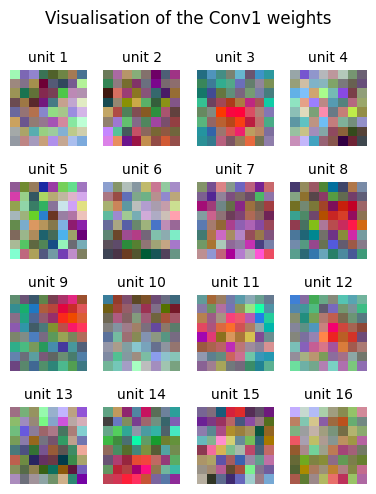

In [6]:
# conv1 weights (kernels) visualisation - 16 units
w1 = net.state_dict()['conv1.weight']
w1 = np.transpose(w1, (0, 2, 3, 1)) # transform to visualisation format in rgb state

# visualise the weights as RGB images
for i in range(w1.shape[0]): # loop through each unit
    plt.subplot(4, 4, i+1)
    plt.axis('off')
    to_show = (w1[i] - w1[i].min()) / (w1[i].max() - w1[i].min()) # normalise to [0, 1]
    plt.imshow(to_show)
    plt.title('unit ' + str(i+1), fontsize=10)
plt.suptitle('Visualisation of the Conv1 weights')
plt.tight_layout()
plt.gcf().set_size_inches(4, 5)
plt.show()

# Lab Recording Room

Where you collect neural responses

In [7]:
# experiment settings
batch_num = 50
batch_size = 1000
zero_mean = True
layer = 'conv1'

In [26]:
act_conv2, noise2 = JacoActRecorder(layer, net, batch_num=batch_num, batch_size=batch_size, zero_mean=zero_mean)
print(noise2.min(), noise2.max(), noise2.mean())

100%|██████████| 50/50 [00:10<00:00,  4.90it/s]


Activation recording completed


100%|██████████| 32/32 [00:00<00:00, 357.39it/s]


Shape of activation response list: torch.Size([32, 50000])
Shape of noise list: torch.Size([50000, 64, 64, 3])
tensor(-127.5000) tensor(127.5000) tensor(0.0008)


In [27]:
# save the activation and noise data
torch.save(act_conv2, './rwa_data/jaco/jaco_rand_0mean/act2.pt')
torch.save(noise2, './rwa_data/jaco/jaco_rand_0mean/noise2.pt')

# Conv1 - Zero Mean [-127.5, 127,5]

The noise input follows the requirements of STA - zero mean, symmetric noise distribution for unbiased estimation. \
However, it is important to note that the model never received negative inputs during training (since image data).

In [8]:
# load existing data if already recorded
act_conv1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/act1.pt')
noise1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/noise1.pt')
rf1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf1.pt')
rf_corr1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf_corr1.pt')
correlation1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/correlation1.pt')
rf_cropped1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf_cropped1.pt')
cov1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/cov1.pt')
# eigen1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/eigen1.pt')

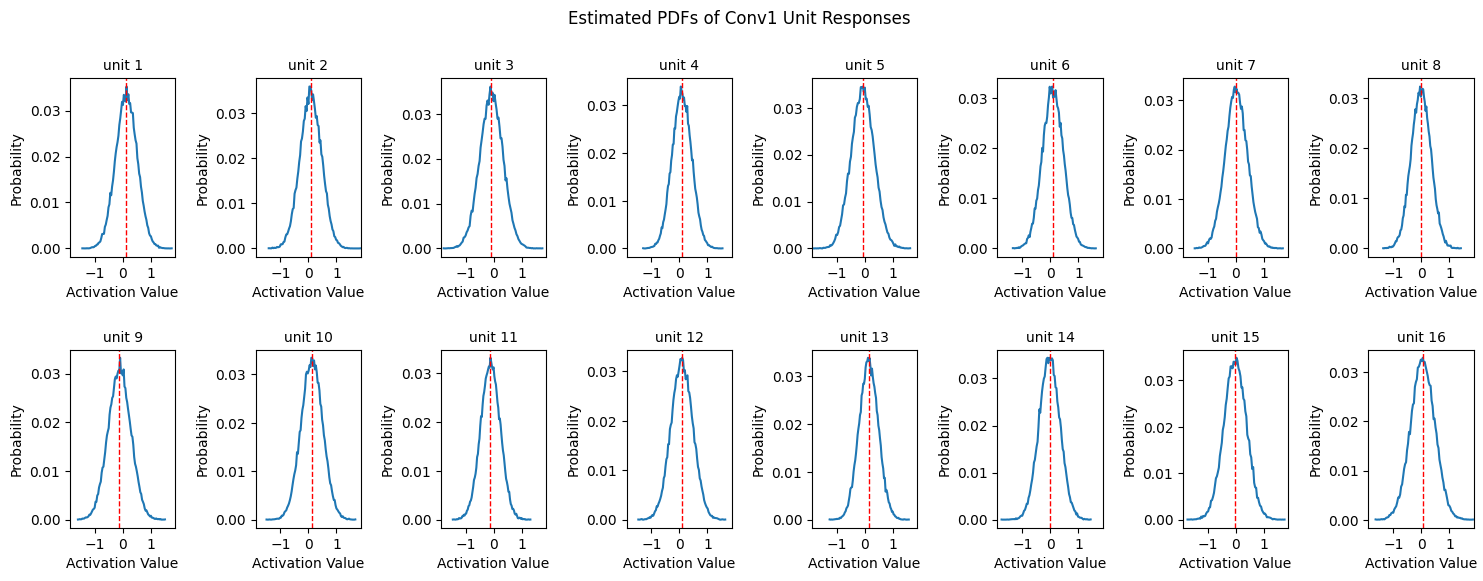

In [9]:
# PDFs of conv1 responses
for i in range(act_conv1.shape[0]):
    # plot initialisation
    plt.subplot(2, 8, i+1)
    plt.xlim(act_conv1.min(), act_conv1.max())
    
    # plot the PDF of the activation values
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv1[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv1[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 5)

plt.suptitle('Estimated PDFs of Conv1 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 6)
plt.show()

RWA - STA

In [133]:
# RWA
rf1 = RWA(act_conv1, noise1)

100%|██████████| 800000/800000 [00:59<00:00, 13383.47it/s]

Shape of receptive field list: torch.Size([16, 64, 64, 3])


In [135]:
# Save the RWA data
torch.save(rf1, './rwa_data/jaco/jaco_rand_0mean/rf1.pt')

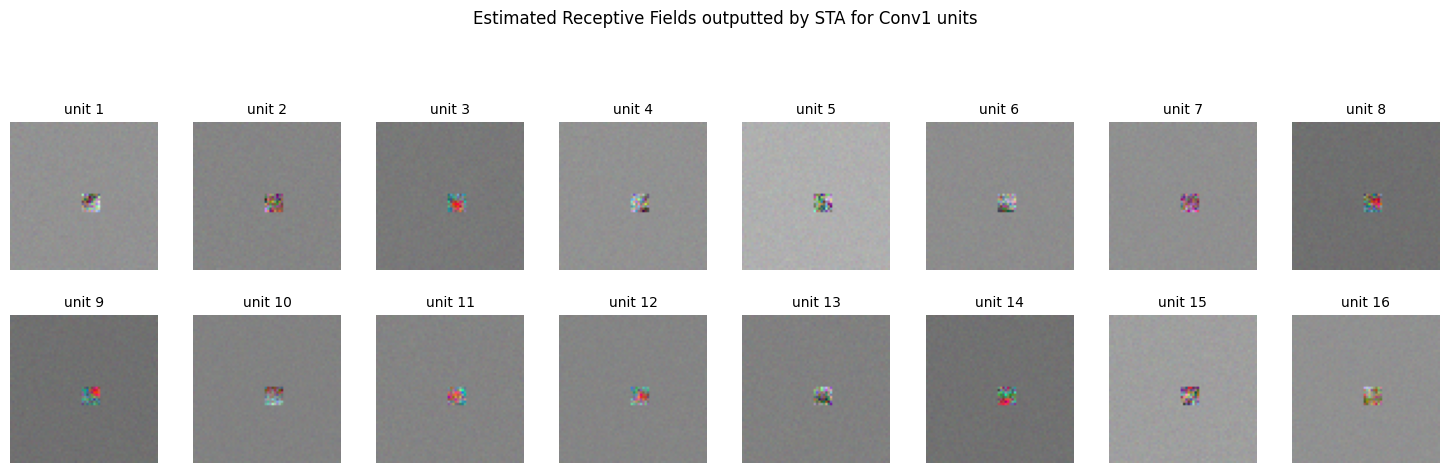

In [10]:
# Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(2, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv1 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5.5)
plt.show()

RWA - Corr

In [137]:
rf_corr1 = torch.zeros(rf1.shape)
for i in range(rf1.shape[3]):
    rf_corr1[:, :, :, i] = CorrRWA(act_conv1, noise1[:, :, :, i])

100%|██████████| 65536/65536 [01:48<00:00, 605.21it/s]


In [138]:
# Save the RWA data
torch.save(rf_corr1, './rwa_data/jaco/jaco_rand_0mean/rf_corr1.pt')

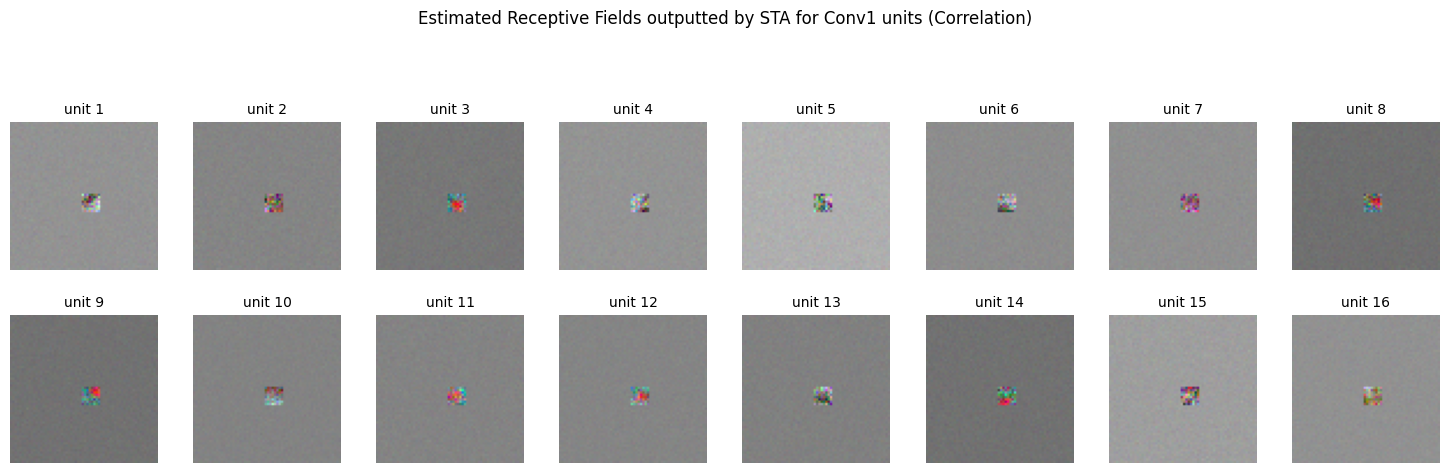

In [11]:
# Visualise the RWA output as image plots
for i in range(rf_corr1.shape[0]):
    plt.subplot(2, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_corr1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv1 units (Correlation)')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5.5)
plt.show()

Correlation

In [140]:
# calculate the Pearson correlation between the RFs and the input noise
correlation1 = torch.zeros(rf1.shape[1], rf1.shape[2], rf1.shape[3])
for i in range(rf1.shape[3]):
    correlation1[:, :, i] = CorrLoc(noise1[:, :, :, i], act_conv1)

100%|██████████| 65536/65536 [01:53<00:00, 576.50it/s]


In [145]:
# save the correlation data
torch.save(correlation1, './rwa_data/jaco/jaco_rand_0mean/correlation1.pt')

In [146]:
# crop the RFs
rf_cropped1 = []
for i in range(rf1.shape[3]):
    tmp, _ = RfCrop(correlation1[:, :, i], rf1[:, :, :, i])
    rf_cropped1.append(tmp)
rf_cropped1 = torch.stack(rf_cropped1, dim=3)

In [147]:
# save the cropped RFs
torch.save(rf_cropped1, './rwa_data/jaco/jaco_rand_0mean/rf_cropped1.pt')

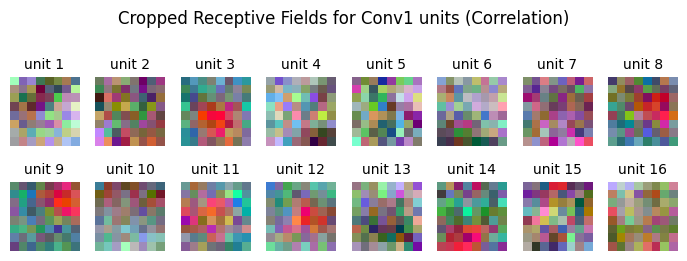

In [12]:
# display cropped RFs
for i in range(rf_cropped1.shape[0]):
    plt.subplot(2, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_cropped1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Cropped Receptive Fields for Conv1 units (Correlation)')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(7, 3)
plt.show()

RWC

In [54]:
noise_cropped1 = torch.zeros(noise1.shape[0], rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
for i in range(noise_cropped1.shape[3]):
    tmp, _ = RfCrop(correlation1[:, :, i], noise1[:, :, :, i])
    noise_cropped1[:, :, :, i] = tmp
print(noise_cropped1.shape)

torch.Size([50000, 8, 8, 3])


In [150]:
cov1 = torch.zeros(rf_cropped1.shape[0], rf_cropped1.shape[1]*rf_cropped1.shape[2], rf_cropped1.shape[1]*rf_cropped1.shape[2], rf_cropped1.shape[3])
for i in range(rf_cropped1.shape[3]): # cov matrix channel by channel
    cov1[:, :, :, i] = RWC(act_conv1, noise_cropped1[:, :, :, i], rf_cropped1[:, :, :, i], zero_mean=zero_mean)

100%|██████████| 800000/800000 [00:19<00:00, 40659.56it/s]


In [151]:
# save the covariance data
torch.save(cov1, './rwa_data/jaco/jaco_rand_0mean/cov1.pt')

In [15]:
# eigen analysis - conv1
num_units = cov1.shape[0]
eigen1 = [[] for i in range(cov1.shape[3])] # 1 for each channel
with tqdm(total = num_units * cov1.shape[3]) as pbar:
    for i in range(num_units):
        for j in range(cov1.shape[3]): # go through each channel
            eigen = np.linalg.eigh(cov1[i, :, :, j])
            eigen1[j].append(eigen)
            pbar.update(1)

100%|██████████| 48/48 [00:00<00:00, 532.15it/s]


In [16]:
# save the eigenvalues and eigenvectors
with open('./rwa_data/jaco/jaco_rand_0mean/eigen1.pkl', 'wb') as f:
    pickle.dump(eigen1, f)

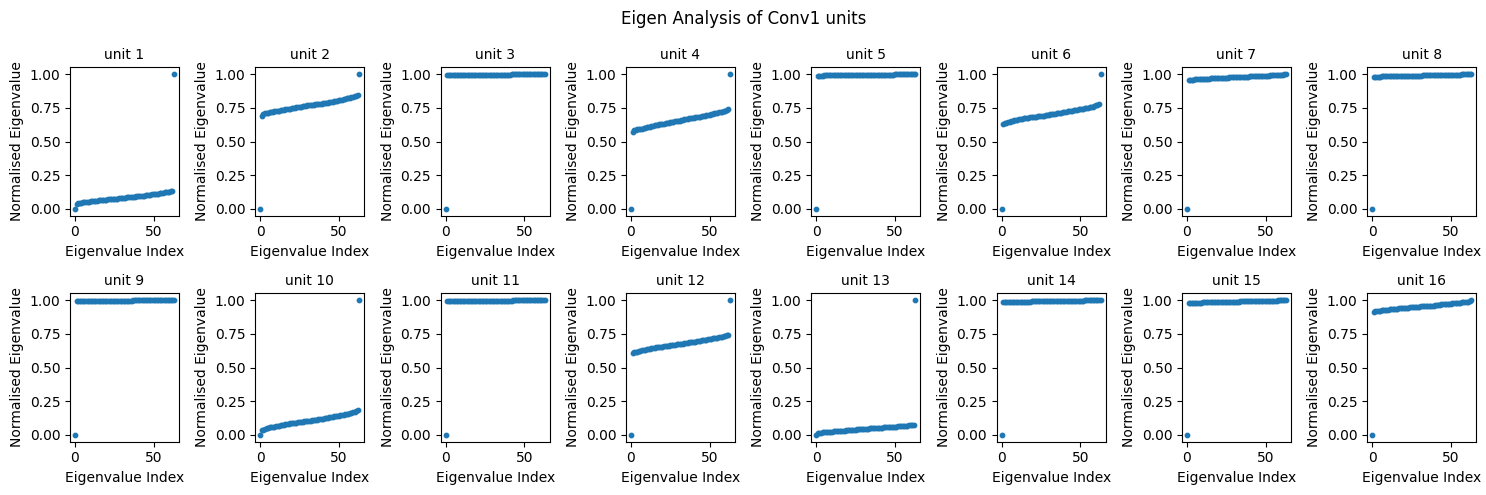

In [17]:
## conv1 eigenvalues
channel = 0

# plot the eigenvalues for each unit - all eigenvalues
for i in range(len(eigen1[channel])): # each unit
    plt.subplot(2, 8, i+1)
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if list is not empty
        # plot the eigenvalues for selected channel only
        eigenvalues = eigen1[channel][i][0]
        eigenvalues = (eigenvalues - eigenvalues.min()) / (eigenvalues.max() - eigenvalues.min()) # normalise to [0, 1]
        plt.scatter(range(len(eigenvalues)), eigenvalues, s=10)
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.xlabel('Eigenvalue Index')
        plt.ylabel('Normalised Eigenvalue')
        # change figure size
        plt.gcf().set_size_inches(13, 5)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        # turn off axis
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
plt.suptitle('Eigen Analysis of Conv1 units')
plt.tight_layout()
plt.gcf().set_size_inches(15, 5)
plt.show()

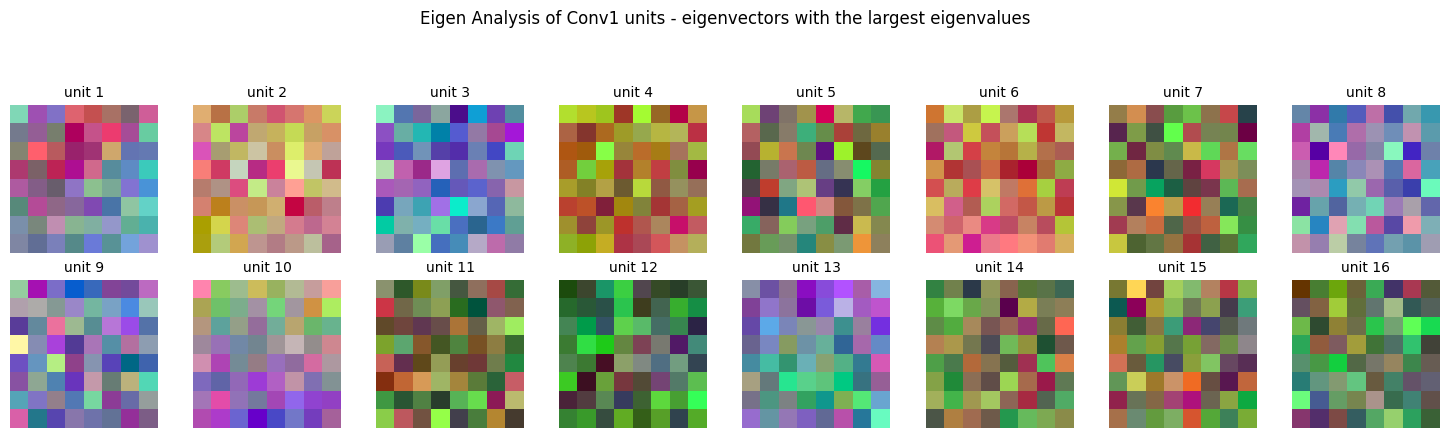

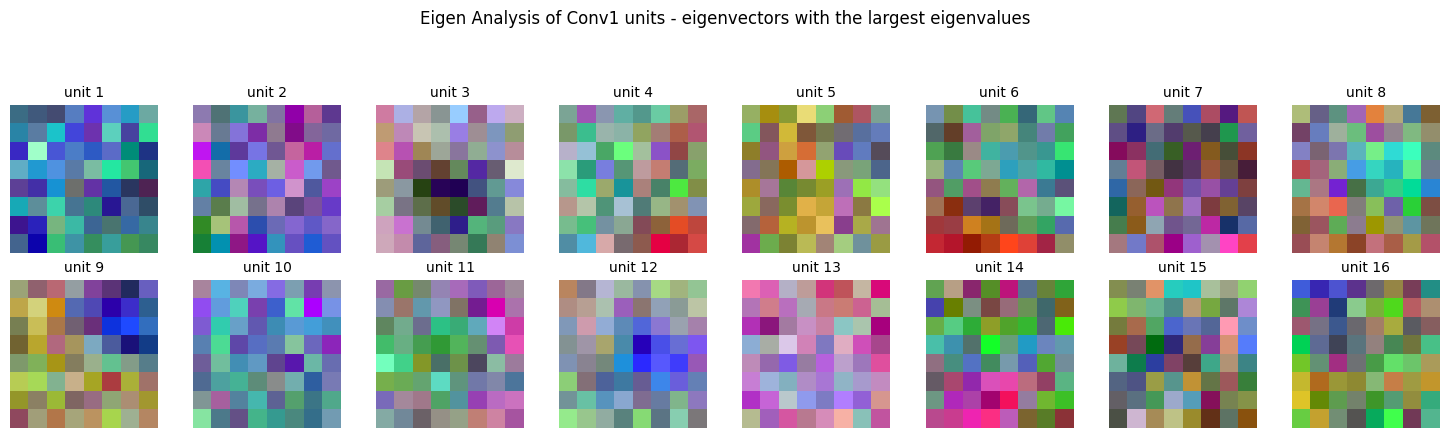

In [19]:
## eigenvectors visualisation

# largest eigenvalues
for i in range(len(eigen1[channel])): # each unit
    to_show = torch.zeros(8, 8, 3)
    plt.subplot(2, 8, i+1)
    plt.axis('off')
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0:
        for j in range(3): # append each channel
            eigenvector = eigen1[j][i][1] # given channel for a given unit
            to_show[:, :, j] = torch.tensor(eigenvector[:, -1].reshape(8, 8)) # select the eigenvector with the largest eigenvalue
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min())
        plt.imshow(to_show) # normalise to [0, 1]
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

plt.suptitle('Eigen Analysis of Conv1 units - eigenvectors with the largest eigenvalues') 
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5)
plt.show()

# smallest eigenvalues
plt.figure()
for i in range(len(eigen1[channel])): # each unit
    to_show = torch.zeros(8, 8, 3)
    plt.subplot(2, 8, i+1)
    plt.axis('off')
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0:
        for j in range(3): # append each channel
            eigenvector = eigen1[j][i][1] # given channel for a given unit
            to_show[:, :, j] = torch.tensor(eigenvector[:, 0].reshape(8, 8)) # select the eigenvector with the smallest eigenvalue
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min())
        plt.imshow(to_show) # normalise to [0, 1]
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

plt.suptitle('Eigen Analysis of Conv1 units - eigenvectors with the largest eigenvalues') 
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5)
plt.show()

PCA

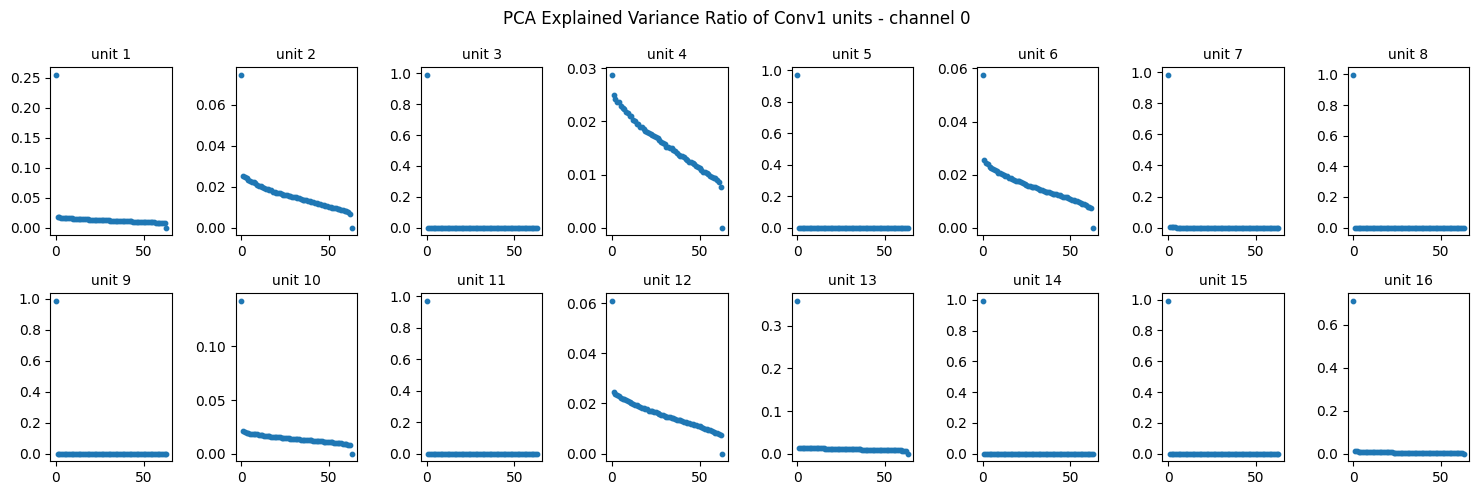

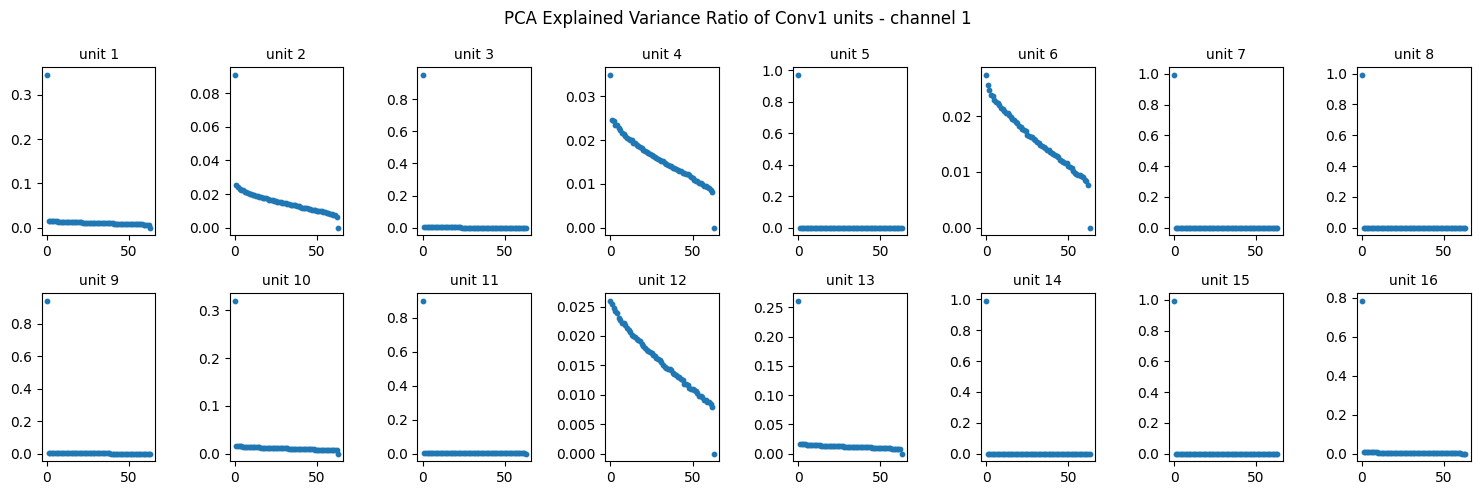

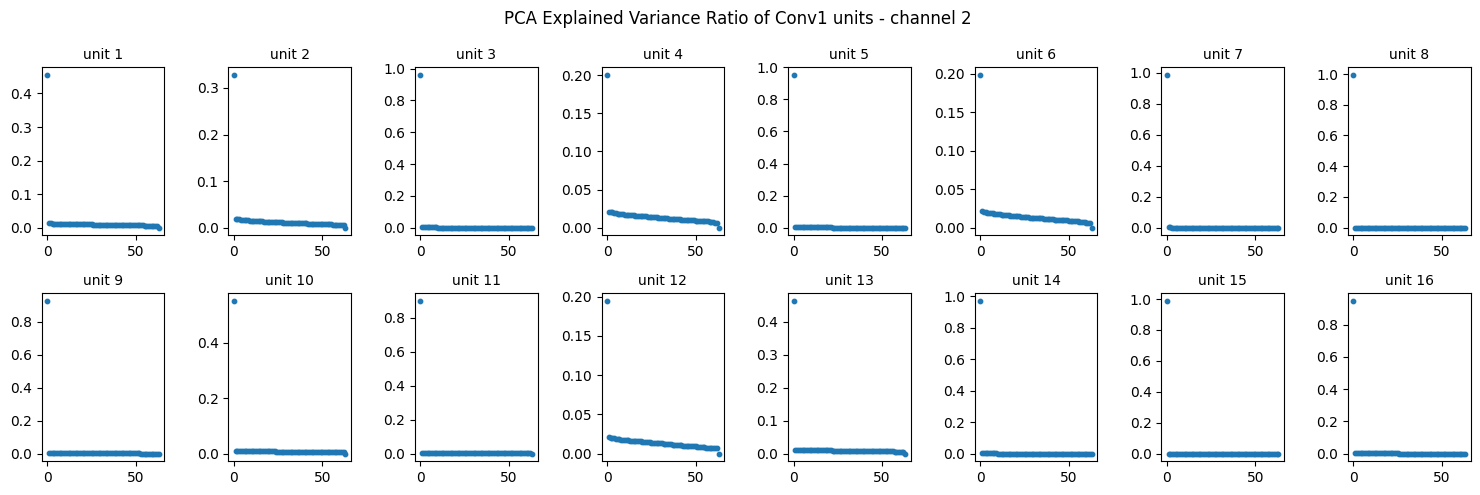

In [20]:
# PCA explained variance
pca1_ev = torch.zeros(cov1.shape[0], cov1.shape[1], cov1.shape[3])
for unit in range(cov1.shape[0]):
    for channel in range(cov1.shape[3]):
        pca = PCA()
        pca.fit(cov1[unit, :, :, channel])
        pca1_ev[unit, :, channel] = torch.tensor(pca.explained_variance_ratio_)

channel = 0
plt.figure()
for unit in range(cov1.shape[0]):
    plt.subplot(2, 8, unit+1)
    plt.scatter(range(len(pca1_ev[unit, :, channel])), pca1_ev[unit, :, channel], s=10)
    plt.gcf().set_size_inches(13, 5)
    plt.title('unit ' + str(unit+1), fontsize=10)

plt.suptitle('PCA Explained Variance Ratio of Conv1 units - channel ' + str(channel))
plt.tight_layout()
plt.gcf().set_size_inches(15, 5)

channel = 1
plt.figure()
for unit in range(cov1.shape[0]):
    plt.subplot(2, 8, unit+1)
    plt.scatter(range(len(pca1_ev[unit, :, channel])), pca1_ev[unit, :, channel], s=10)
    plt.gcf().set_size_inches(13, 5)
    plt.title('unit ' + str(unit+1), fontsize=10)

plt.suptitle('PCA Explained Variance Ratio of Conv1 units - channel ' + str(channel))
plt.tight_layout()
plt.gcf().set_size_inches(15, 5)

channel = 2
plt.figure()
for unit in range(cov1.shape[0]):
    plt.subplot(2, 8, unit+1)
    plt.scatter(range(len(pca1_ev[unit, :, channel])), pca1_ev[unit, :, channel], s=10)
    plt.gcf().set_size_inches(13, 5)
    plt.title('unit ' + str(unit+1), fontsize=10)

plt.suptitle('PCA Explained Variance Ratio of Conv1 units - channel ' + str(channel))
plt.tight_layout()
plt.gcf().set_size_inches(15, 5)

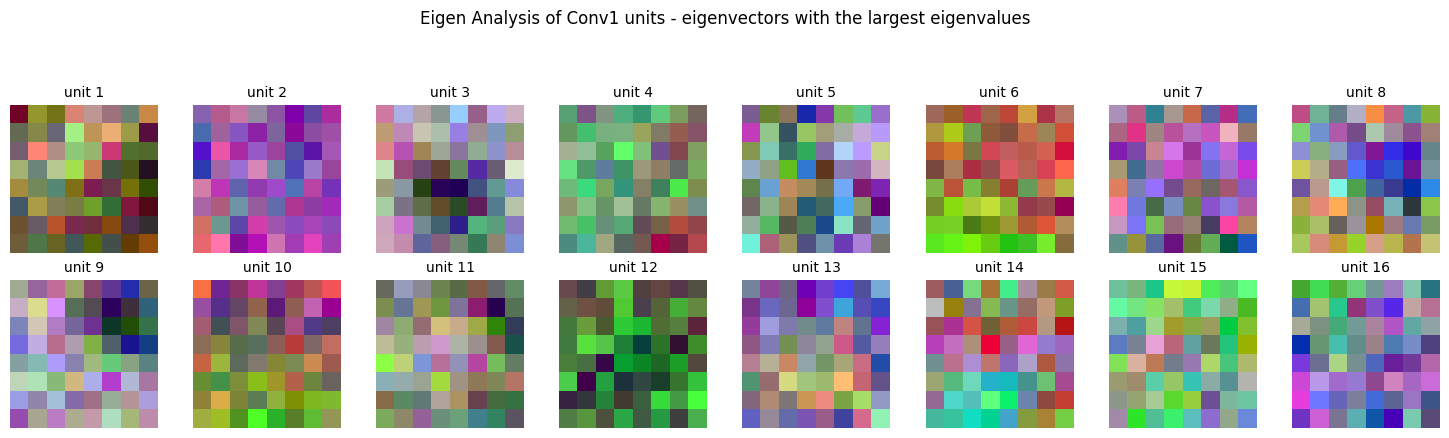

In [23]:
pca1 = torch.zeros(rf_cropped1.shape)
for unit in range(cov1.shape[0]):
    for channel in range(cov1.shape[3]):
        pca = PCA()
        pca.fit(cov1[unit, :, :, channel])
        pca1[unit, :, :, channel] = torch.tensor(pca.components_[0].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2]))
        
for i in range(pca1.shape[0]): # each unit
    to_show = torch.zeros(8, 8, 3)
    plt.subplot(2, 8, i+1)
    plt.axis('off')
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0:
        to_show = pca1[i]
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min())
        plt.imshow(to_show) # normalise to [0, 1]
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

plt.suptitle('Eigen Analysis of Conv1 units - eigenvectors with the largest eigenvalues') 
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5)
plt.show()

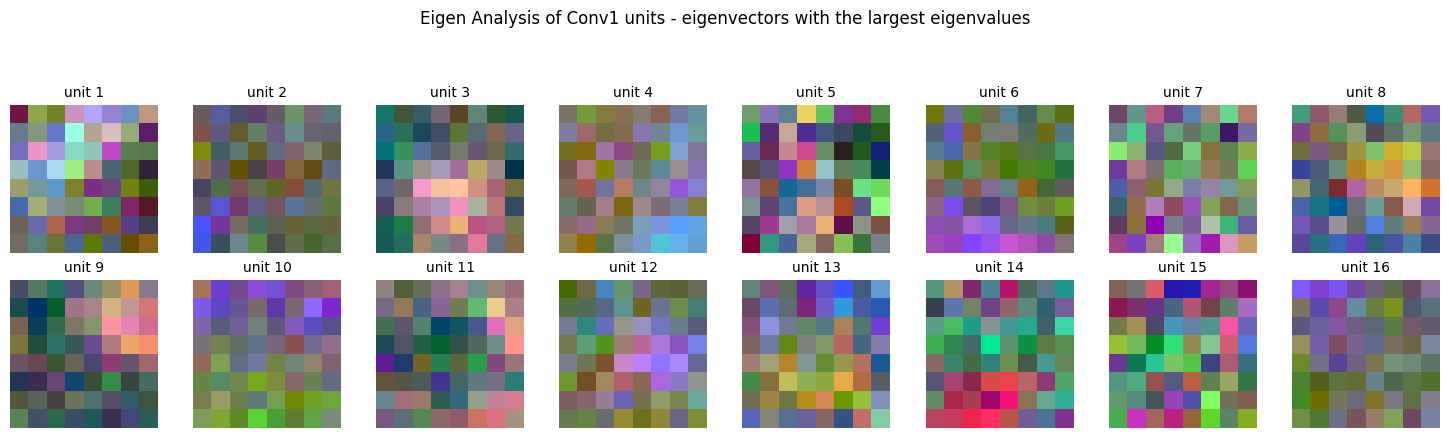

In [24]:
pca1 = torch.zeros(rf_cropped1.shape)
for unit in range(cov1.shape[0]):
    for channel in range(cov1.shape[3]):
        pca = PCA()
        tmp = pca.fit_transform(cov1[unit, :, :, channel])
        pca1[unit, :, :, channel] = torch.tensor(tmp[:, 0].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2]))

for i in range(pca1.shape[0]): # each unit
    to_show = torch.zeros(8, 8, 3)
    plt.subplot(2, 8, i+1)
    plt.axis('off')
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0:
        to_show = pca1[i]
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min())
        plt.imshow(to_show) # normalise to [0, 1]
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

plt.suptitle('Eigen Analysis of Conv1 units - eigenvectors with the largest eigenvalues') 
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5)
plt.show()

PCA - 3 channels together

In [14]:
# crop noise
noise_cropped1 = torch.zeros(noise1.shape[0], rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
for i in range(noise_cropped1.shape[3]):
    tmp, _ = RfCrop(correlation1[:, :, i], noise1[:, :, :, i])
    noise_cropped1[:, :, :, i] = tmp
print(noise_cropped1.shape)

torch.Size([50000, 8, 8, 3])


In [15]:
# pre process the data
rf_cropped1_ = rf_cropped1.reshape(rf_cropped1.shape[0], -1, 1)
noise_cropped1_ = noise_cropped1.reshape(noise_cropped1.shape[0], -1, 1)
rf_cropped1_.shape, noise_cropped1_.shape

(torch.Size([16, 192, 1]), torch.Size([50000, 192, 1]))

In [16]:
cov1_ = RWC(act_conv1, noise_cropped1_, rf_cropped1_, zero_mean=zero_mean)

  0%|          | 0/800000 [00:00<?, ?it/s]

100%|██████████| 800000/800000 [03:50<00:00, 3469.91it/s]


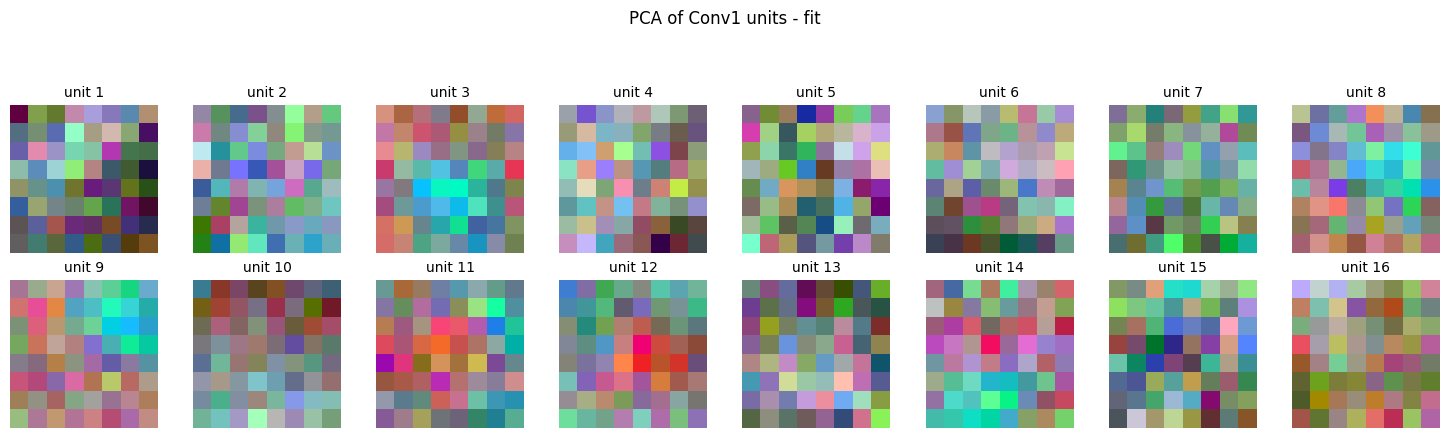

In [37]:
# fit
pca = PCA()
for i in range(rf_cropped1.shape[0]):
    plt.subplot(2, 8, i+1)
    plt.axis('off')
    x = pca.fit(cov1_[i])
    # x = x.reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
    x = pca.components_[0].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    plt.imshow(to_show)
    plt.title('unit ' + str(i+1), fontsize=10)
    
plt.suptitle('PCA of Conv1 units - fit') 
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5)
plt.show()

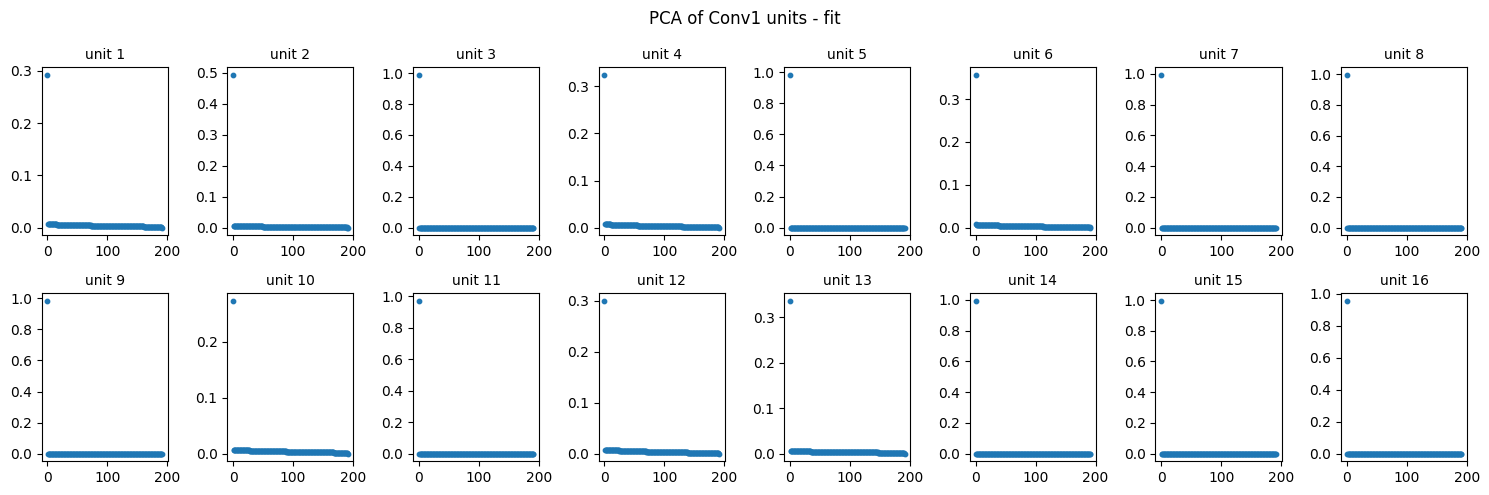

In [35]:
# explained variance (eigen values)
pca = PCA()
for i in range(rf_cropped1.shape[0]):
    plt.subplot(2, 8, i+1)
    x = pca.fit(cov1_[i])
    x = pca.explained_variance_ratio_
    plt.scatter(range(len(x)), x, s=10)
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(15, 5)
    
plt.suptitle('PCA of Conv1 units - fit') 
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5)
plt.show()

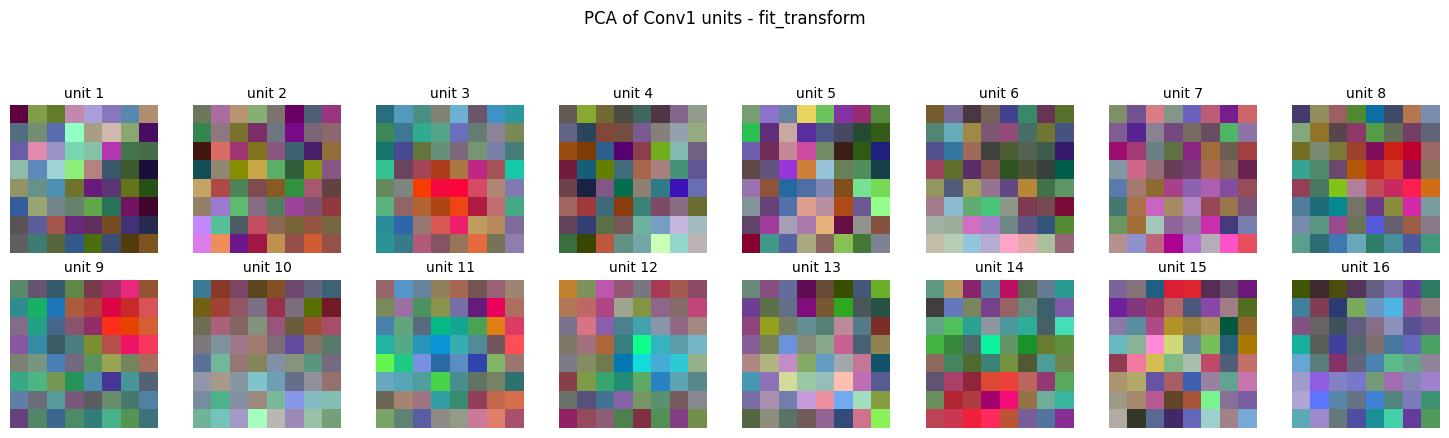

In [39]:
# fit transform
pca = PCA()
for i in range(rf_cropped1.shape[0]):
    plt.subplot(2, 8, i+1)
    plt.axis('off')
    x = pca.fit_transform(cov1_[i])[:, 0]
    x = x.reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
    # x = pca.components_[0].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    plt.imshow(to_show)
    plt.title('unit ' + str(i+1), fontsize=10)

plt.suptitle('PCA of Conv1 units - fit_transform') 
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5)
plt.show()

Phase Weighted Analysis

# Conv1 - Positive Only [0, 255]

In [11]:
# load existing data if already recorded
act_conv1 = torch.load('./rwa_data/jaco/jaco_rand/act1.pt')
noise1 = torch.load('./rwa_data/jaco/jaco_rand/noise1.pt')
rf1 = torch.load('./rwa_data/jaco/jaco_rand/rf1.pt')

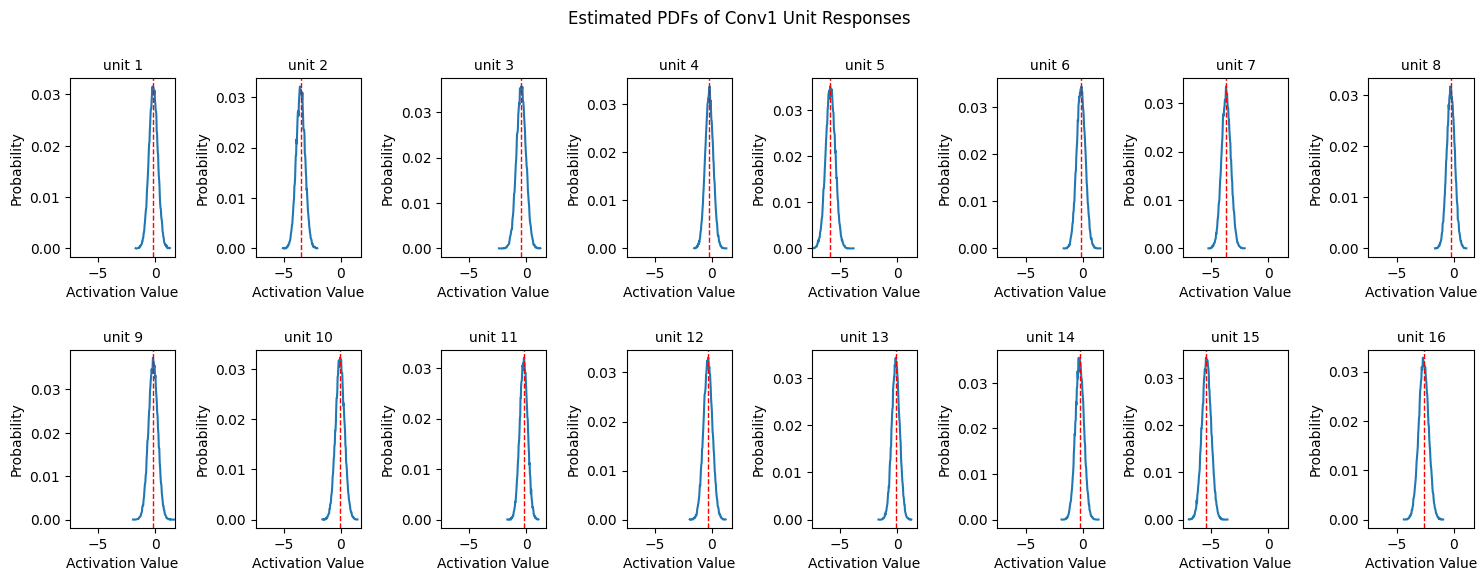

In [18]:
# PDFs of conv1 responses
for i in range(act_conv1.shape[0]):
    plt.subplot(2, 8, i+1)
    plt.xlim(act_conv1.min(), act_conv1.max())
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv1[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv1[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 5)

plt.suptitle('Estimated PDFs of Conv1 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 6)
plt.show()

RWA

In [19]:
# RWA
rf1 = RWA(layer, net, act_conv1, noise1, NBatches=NBatches, BSize=BSize)

100%|██████████| 800000/800000 [01:17<00:00, 10366.87it/s]

Shape of receptive field list: torch.Size([16, 64, 64, 3])


In [20]:
# Save the RWA data
torch.save(rf1, './rwa_data/jaco/jaco_rand/rf1.pt')

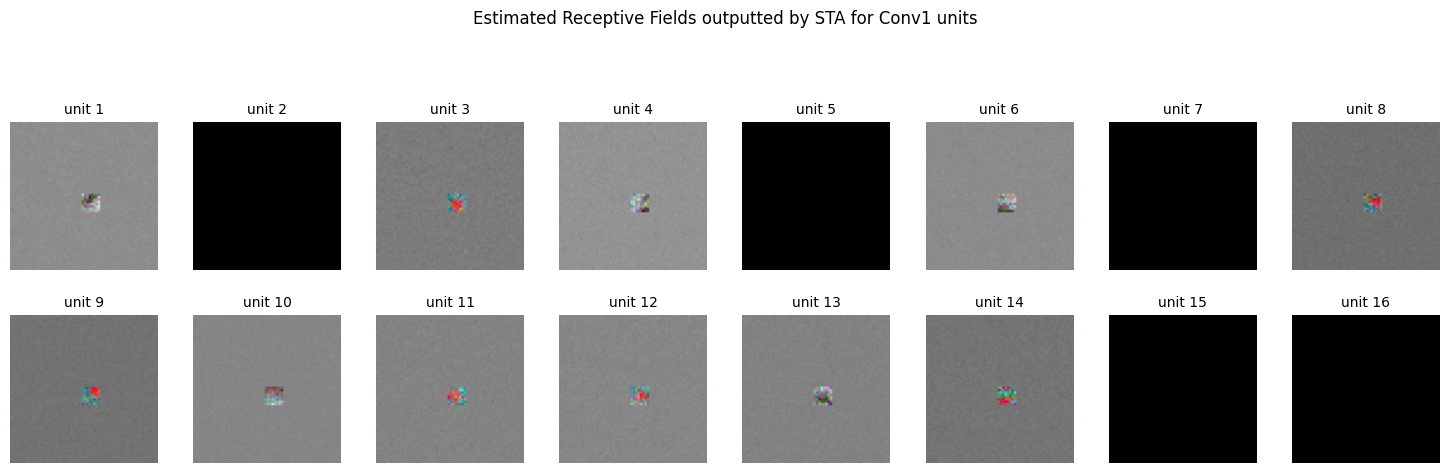

In [21]:
# Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(2, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i]
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0:
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv1 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5.5)
plt.show()

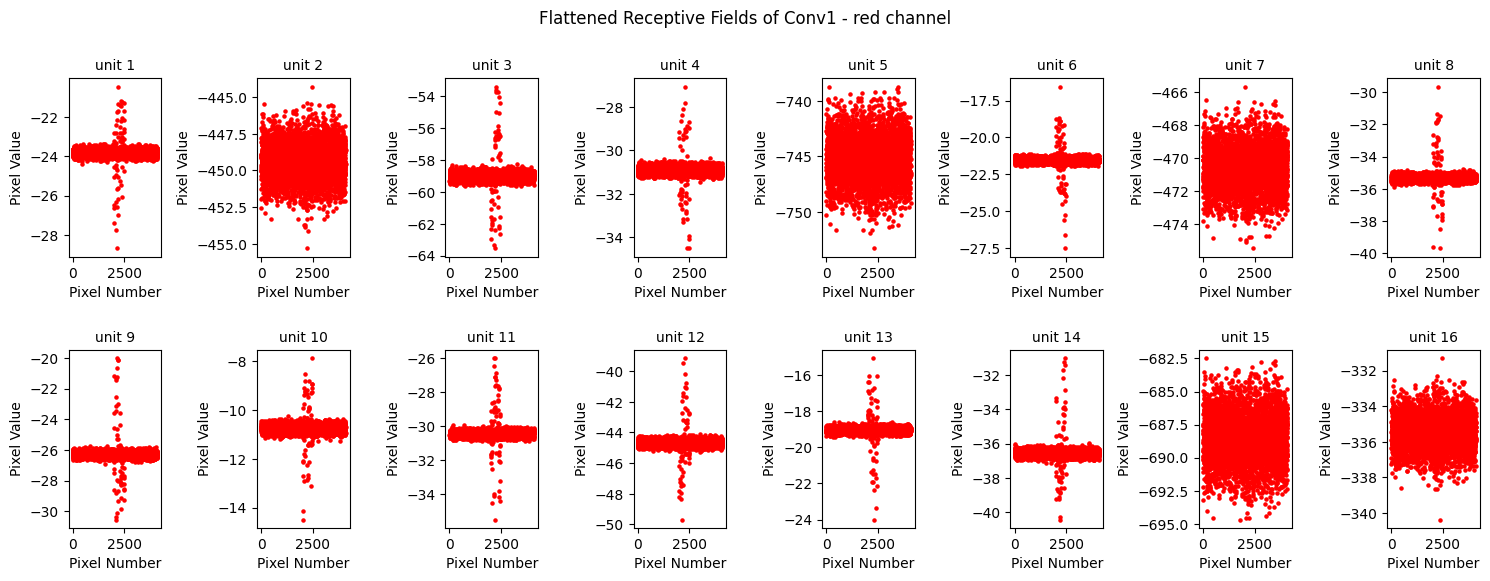

In [24]:
# Flattened RWA Visualisation
channel = 0
color = ['red', 'green', 'blue']

for i in range(rf1.shape[0]):
    plt.subplot(2, 8, i+1) # nrows, ncols, index
    plt.xlabel('Pixel Number')
    plt.ylabel('Pixel Value')
    to_show = rf1[i, :, :, channel]
    if to_show.any() != 0:
        to_show = to_show.flatten() # flatten the receptive field into 1 x 4096
        plt.scatter(range(len(to_show)), to_show, s=5, c=color[channel])
        plt.gcf().set_size_inches(15, 5)
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

plt.suptitle(f'Flattened Receptive Fields of Conv1 - {color[channel]} channel')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 6)
plt.show()

RWC

In [ ]:
# load existing data if already recorded
cov1 = torch.load('./rwa_data/jaco/jaco_rand/cov1.pt')
eigen1 = torch.load('./rwa_data/jaco/jaco_rand/eigen1.pt')

In [ ]:
# RWC
cov1 = RWC(layer, net, act_conv1, noise1, rf1, NBatches=NBatches, BSize=BSize, zeroMean=zeroMean, absolute=True)

In [ ]:
torch.save(cov1, './rwa_data/jaco/jaco_rand/cov1.pt')

In [ ]:
# eigen analysis - conv1
NUnits = cov1.shape[0]
eigen1 = []
with tqdm(total=NUnits) as pbar:
    for i in range(NUnits):
        eigen1.append(eigenAnalysis(cov1, i))
        pbar.update(1)

In [ ]:
# save the eigenvalues and eigenvectors
with open('./rwa_data/jaco/jaco_rand/eigen1.pkl', 'wb') as f:
    pickle.dump(eigen1, f)

In [ ]:
# conv1 eigenvalues

# plot the eigenvalues for each unit - all eigenvalues
for i in range(len(eigen1)): # each unit
    plt.subplot(2, 8, i+1)
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if list is not empty
        # plot the eigenvalues for red (first) channel only
        eigenvalues = eigen1[i][0].eigenvalues
        eigenvalues = (eigenvalues - eigenvalues.min()) / (eigenvalues.max() - eigenvalues.min()) # normalise to [0, 1]
        plt.scatter(range(len(eigenvalues)), eigenvalues, s=10)
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.xlabel('Eigenvalue Index')
        plt.ylabel('Normalised Eigenvalue')
        # change figure size
        plt.gcf().set_size_inches(13, 5)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        # turn off axis
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
plt.suptitle('Eigen Analysis of Conv1 units')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5)
plt.show()

# plot the eigenvalues for each unit - excludes the largest eigenvalue
plt.figure()
for i in range(len(eigen1)): # each unit
    plt.subplot(2, 8, i+1)
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if list is not empty
        # plot the eigenvalues for red (first) channel only
        eigenvalues = eigen1[i][1].eigenvalues
        eigenvalues = (eigenvalues - eigenvalues.min()) / (eigenvalues.max() - eigenvalues.min()) # normalise to [0, 1]
        plt.scatter(range(len(eigenvalues)-1), eigenvalues[:-1], s=10)
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.xlabel('Eigenvalue Index')
        plt.ylabel('Normalised Eigenvalue')
        # change figure size
        plt.gcf().set_size_inches(13, 5)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        # turn off axis
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
plt.suptitle('Eigen Analysis of Conv1 units - excludes the largest eigenvalue')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5)

# plot the eigenvalues for each unit - excludes the smallest eigenvalue
plt.figure()
for i in range(len(eigen1)): # each unit
    plt.subplot(2, 8, i+1)
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if list is not empty
        # plot the eigenvalues for red (first) channel only
        eigenvalues = eigen1[i][0].eigenvalues
        eigenvalues = (eigenvalues - eigenvalues.min()) / (eigenvalues.max() - eigenvalues.min()) # normalise to [0, 1]
        plt.scatter(range(len(eigenvalues)-1), eigenvalues[1:], s=10)
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.xlabel('Eigenvalue Index')
        plt.ylabel('Normalised Eigenvalue')
        # change figure size
        plt.gcf().set_size_inches(13, 5)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        # turn off axis
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
plt.suptitle('Eigen Analysis of Conv1 units - excludes the smallest eigenvalue')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5)

In [ ]:
# eigenvectors visualisation - conv1 LARGEST
for i in range(len(eigen1)): # each unit
    to_show = torch.zeros(64, 64, 3)
    plt.subplot(2, 8, i+1)
    plt.axis('off')
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0:
        for j in range(3): # append each channel
            eigenvector = eigen1[i][j].eigenvectors # given channel for a given unit
            # eigenvector = eigenvector * eigen1[i][j].eigenvalues
            to_show[:, :, j] = eigenvector[:, -1].reshape(64, 64) # select the eigenvector with the largest eigenvalue
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min())
        plt.imshow(to_show) # normalise to [0, 1]
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

plt.suptitle('Eigen Analysis of Conv1 units - eigenvectors with the largest eigenvalues') 
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5)
plt.show()

# eigenvectors visualisation - conv1 SMALLEST
for i in range(len(eigen1)): # each unit
    to_show = torch.zeros(64, 64, 3)
    plt.subplot(2, 8, i+1)
    plt.axis('off')
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0:
        for j in range(3): # append each channel
            eigenvector = eigen1[i][j].eigenvectors # given channel for a given unit
            # eigenvector = eigenvector * eigen1[i][j].eigenvalues
            to_show[:, :, j] = eigenvector[:, 0].reshape(64, 64) # select the eigenvector with the largest eigenvalue
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min())
        plt.imshow(to_show) # normalise to [0, 1]
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

plt.suptitle('Eigen Analysis of Conv1 units - eigenvectors with the smallest eigenvalues') 
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5)
plt.show()

# Conv2 - Zero Mean [-127.5, 127,5]

In [ ]:
# load existing data if already recorded
act_conv2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/act2.pt')
noise2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/noise2.pt')
rf2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf2.pt')
rf_corr2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf_corr2.pt')
correlation2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/correlation2.pt')
rf_cropped2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf_cropped2.pt')
cov2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/cov2.pt')
# eigen2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/eigen2.pt')

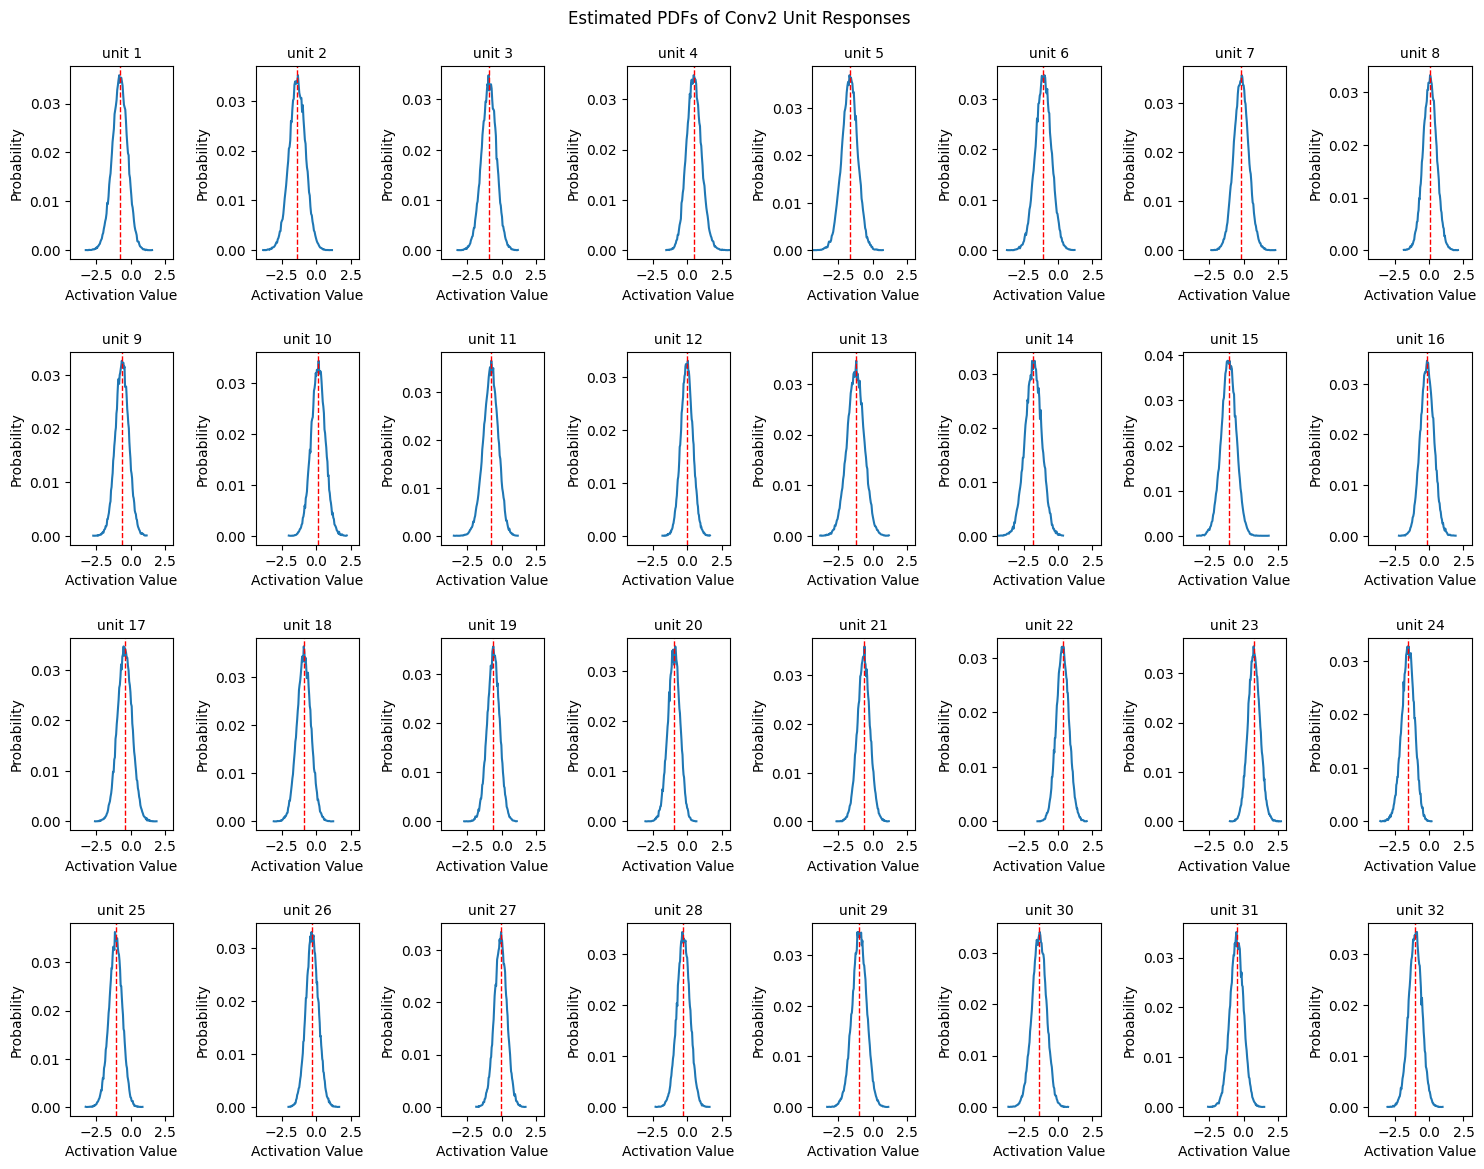

In [29]:
# PDFs of conv1 responses
for i in range(act_conv2.shape[0]):
    # plot initialisation
    plt.subplot(4, 8, i+1)
    plt.xlim(act_conv2.min(), act_conv2.max())
    
    # plot the PDF of the activation values
    if act_conv2[i][act_conv2[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv2[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv2[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 10)

plt.suptitle('Estimated PDFs of Conv2 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 12)
plt.show()

RWA -STA

In [30]:
# RWA
rf2 = RWA(act_conv2, noise2)

  0%|          | 505/1600000 [00:00<05:23, 4941.79it/s]

100%|██████████| 1600000/1600000 [03:21<00:00, 7931.69it/s]


Shape of receptive field list: torch.Size([32, 64, 64, 3])


In [31]:
# Save the RWA data
torch.save(rf2, './rwa_data/jaco/jaco_rand_0mean/rf2.pt')

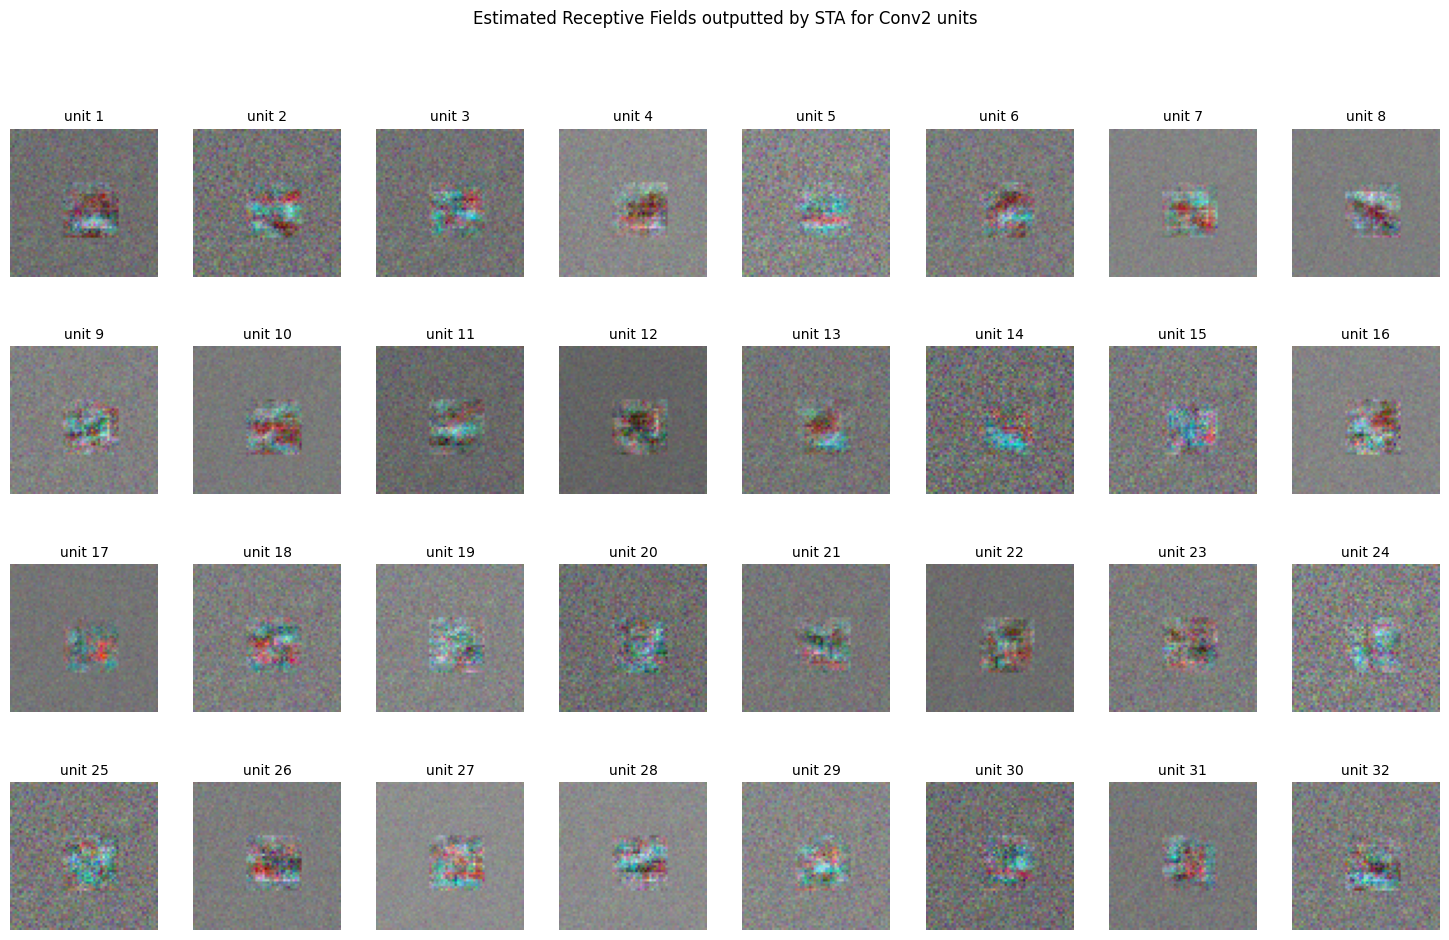

In [32]:
# Visualise the RWA output as image plots
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv2 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()

RWA - Corr

In [33]:
rf_corr2 = torch.zeros(rf2.shape)
for i in range(rf2.shape[3]):
    rf_corr2[:, :, :, i] = CorrRWA(act_conv2, noise2[:, :, :, i])

100%|██████████| 131072/131072 [07:10<00:00, 304.32it/s]


In [34]:
# Save the RWA data
torch.save(rf_corr2, './rwa_data/jaco/jaco_rand_0mean/rf_corr2.pt')

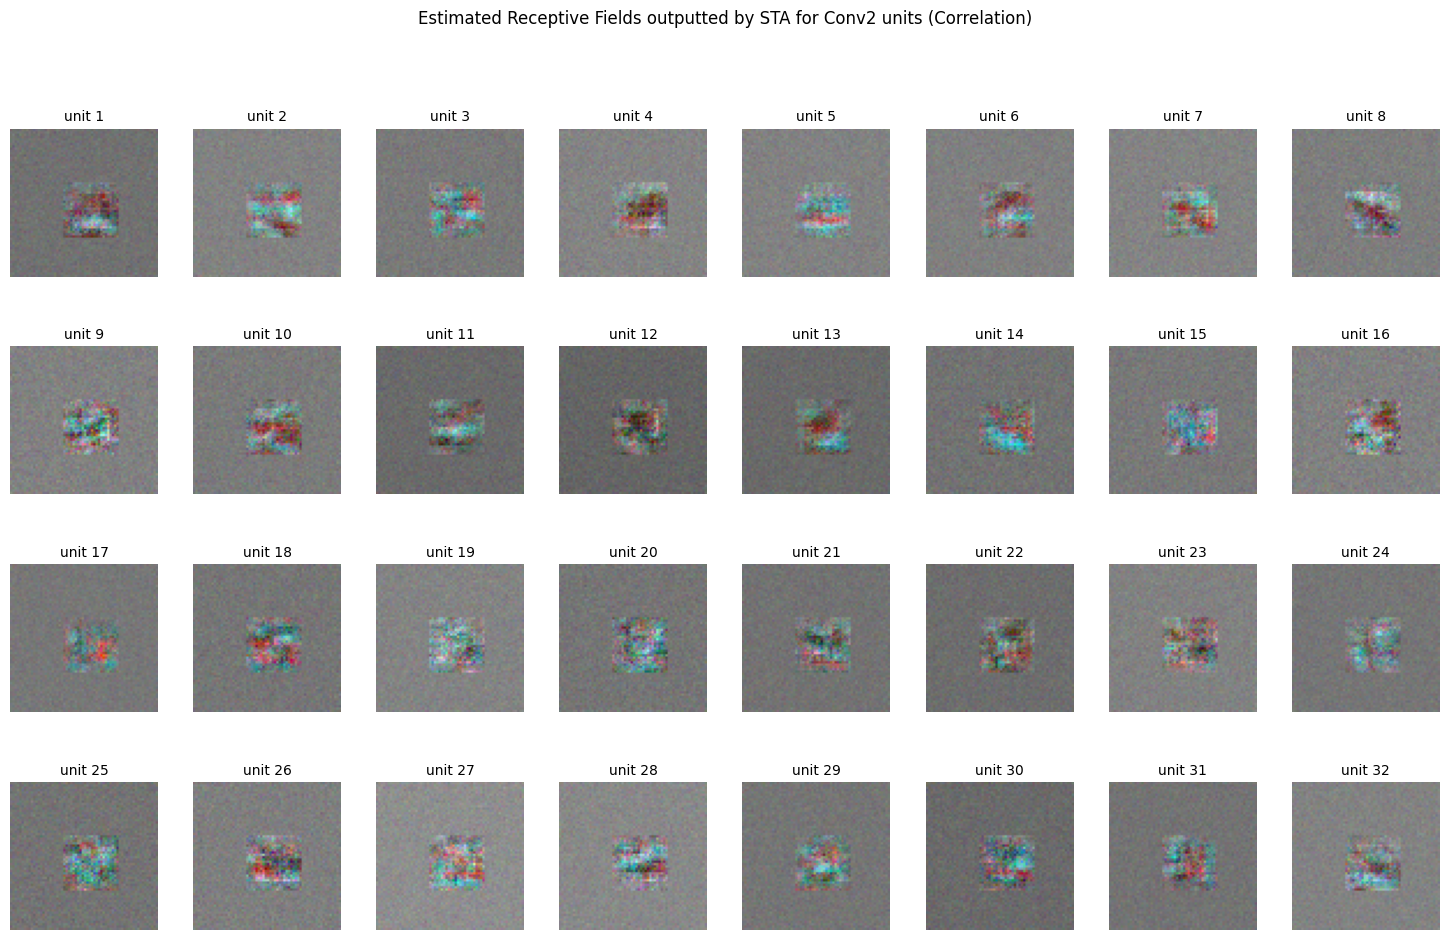

In [35]:
# Visualise the RWA output as image plots
for i in range(rf_corr2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_corr2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv2 units (Correlation)')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()

Correlation

In [36]:
# calculate the Pearson correlation between the RFs and the input noise
correlation2 = torch.zeros(rf2.shape[1], rf2.shape[2], rf2.shape[3])
for i in range(rf2.shape[3]):
    correlation2[:, :, i] = CorrLoc(noise2[:, :, :, i], act_conv2)

100%|██████████| 131072/131072 [09:42<00:00, 225.07it/s]


In [37]:
# save the correlation data
torch.save(correlation2, './rwa_data/jaco/jaco_rand_0mean/correlation2.pt')

In [38]:
# crop the RFs
rf_cropped2 = []
for i in range(rf2.shape[3]):
    tmp, _ = RfCrop(correlation2[:, :, i], rf2[:, :, :, i])
    rf_cropped2.append(tmp)
rf_cropped2 = torch.stack(rf_cropped2, dim=3)

In [39]:
# save the cropped RFs
torch.save(rf_cropped2, './rwa_data/jaco/jaco_rand_0mean/rf_cropped2.pt')

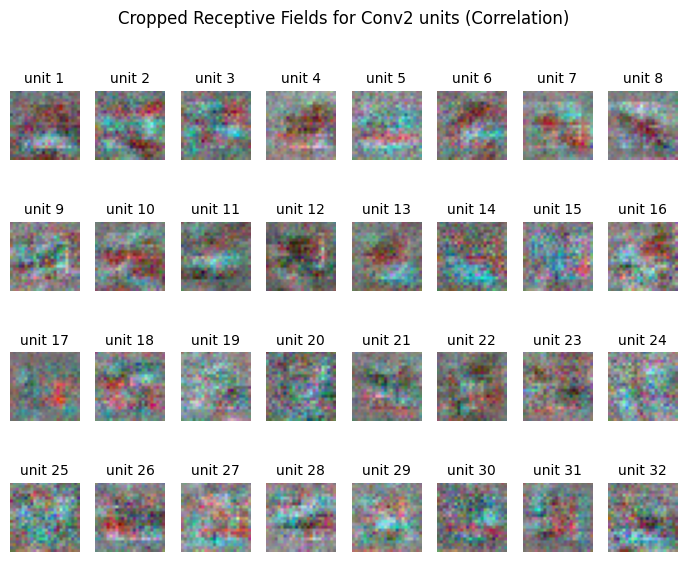

In [41]:
# display cropped RFs
for i in range(rf_cropped2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_cropped2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Cropped Receptive Fields for Conv2 units (Correlation)')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(7, 6)
plt.show()

# Conv2 - Positive Only [0, 255]

In [ ]:
# load existing data if already recorded
act_conv2 = torch.load('./rwa_data/jaco/jaco_rand/act2.pt')
noise2 = torch.load('./rwa_data/jaco/jaco_rand/noise2.pt')
rf2 = torch.load('./rwa_data/jaco/jaco_rand/rf2.pt')

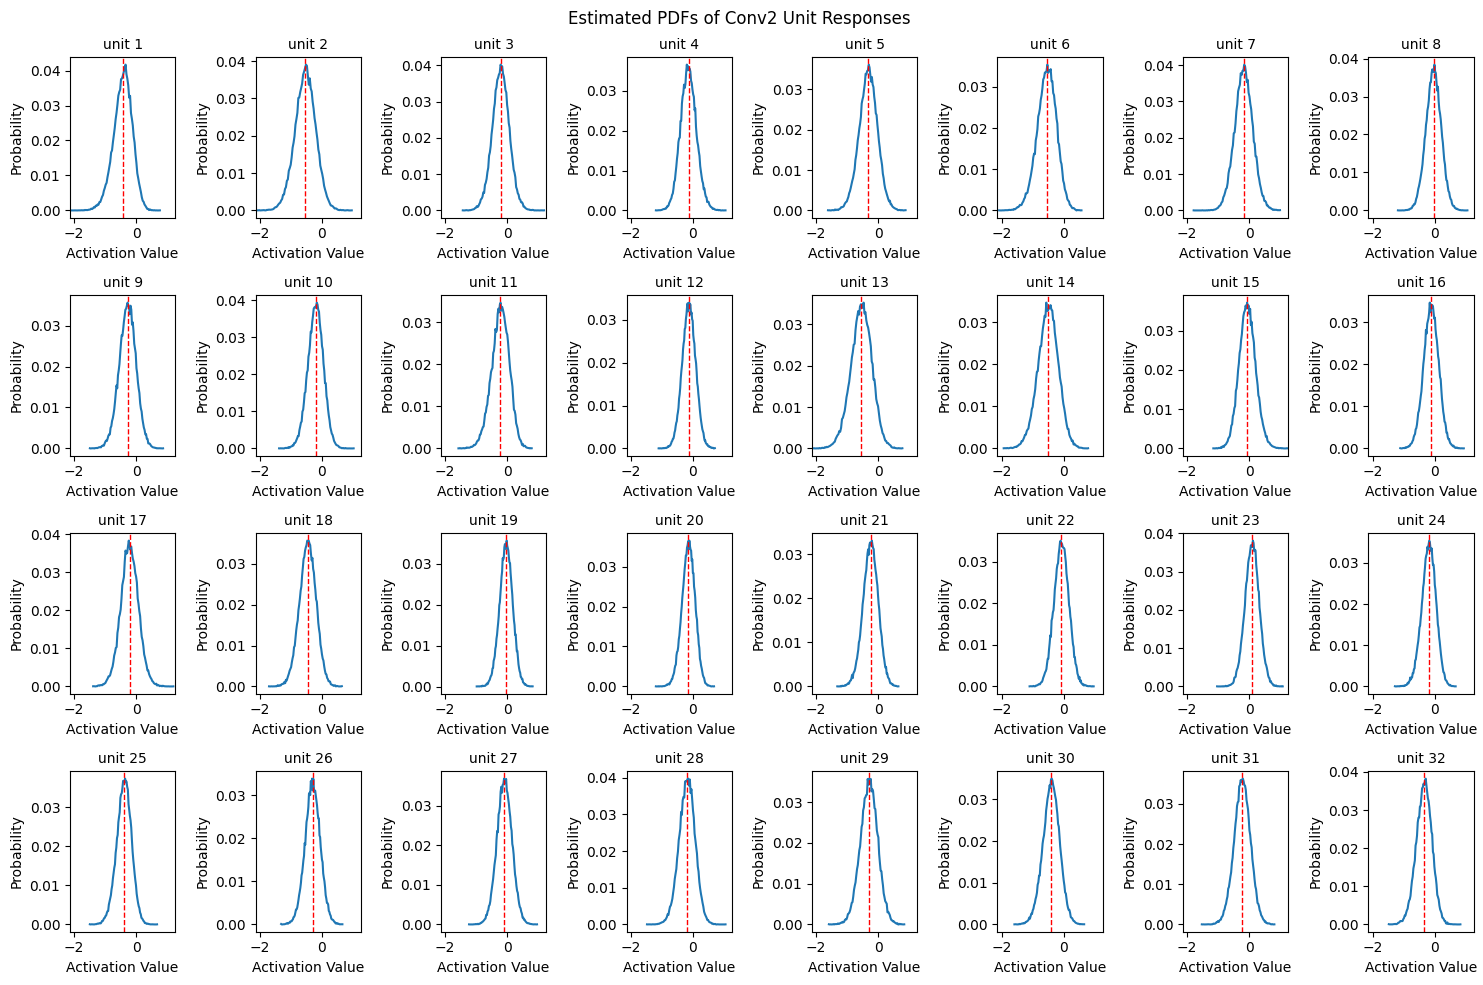

In [39]:
# PDFs of conv2 responses
for i in range(act_conv2.shape[0]):
    plt.subplot(4, 8, i+1)
    plt.xlim(act_conv2.min(), act_conv2.max())
    
    if act_conv2[i][act_conv2[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv2[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv2[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 10)

plt.suptitle('Estimated PDFs of Conv2 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()

RWA

In [40]:
# RWA
rf2 = RWA(layer, net, act_conv2, noise2, NBatches=NBatches, BSize=BSize)

100%|██████████| 1600000/1600000 [02:41<00:00, 9879.88it/s] 

Shape of receptive field list: torch.Size([32, 64, 64, 3])


In [41]:
# Save the RWA data
torch.save(rf2, './rwa_data/jaco/jaco_rand/rf2.pt')

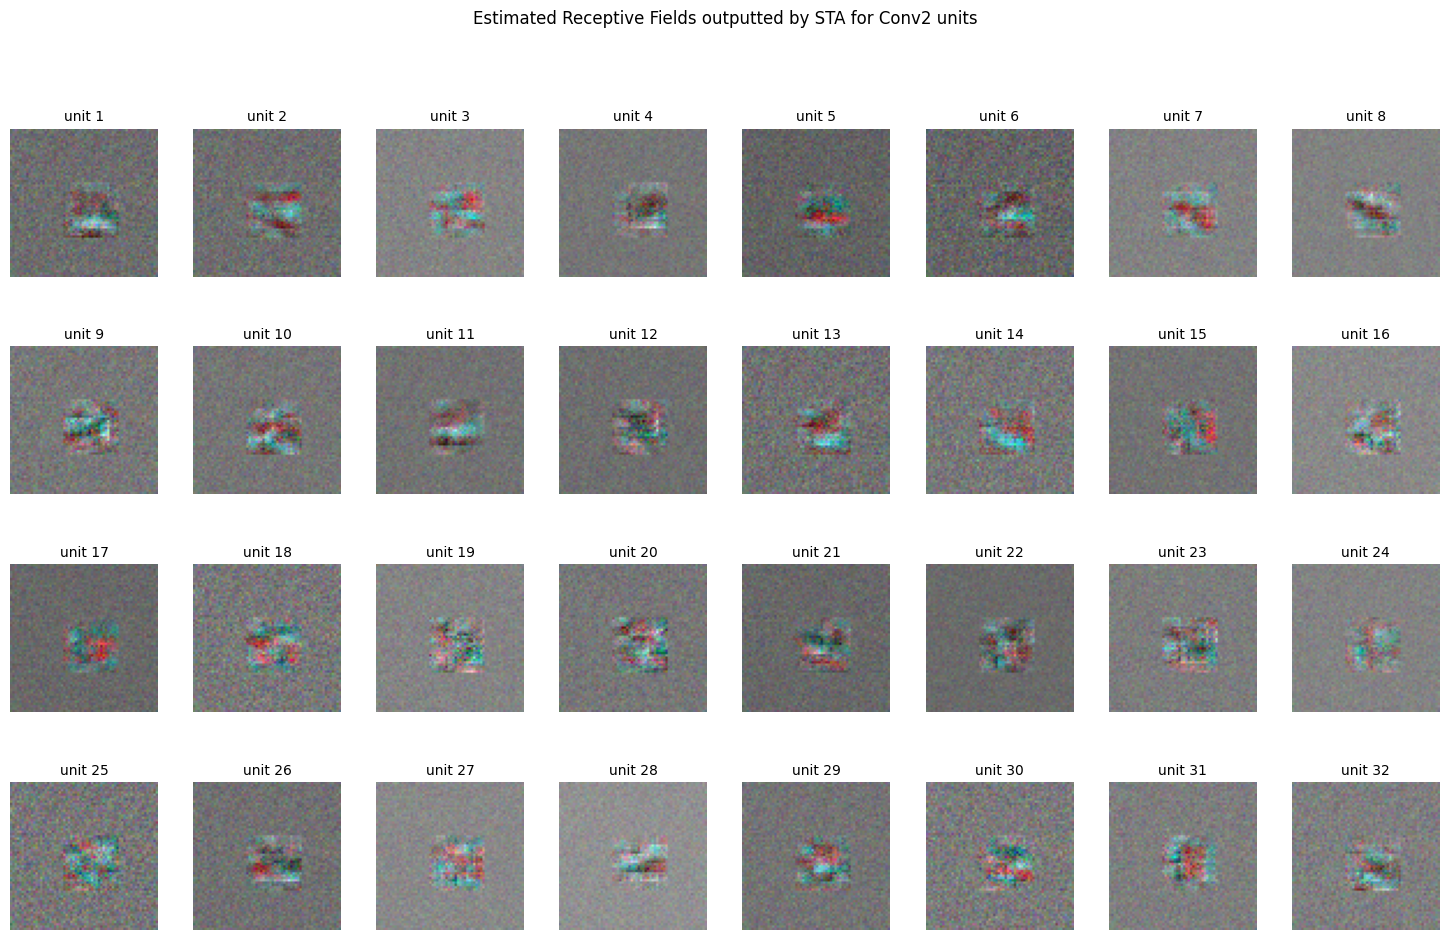

In [42]:
# Visualise the RWA output as image plots
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf2[i]
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0:
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv2 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()